# stage1_sql

This notebook reads data from `response/data/test_data.db` and answers following questions:

1. What was the total revenue to the nearest dollar for customers who have paid by credit card?
2. What percentage of customers who have purchased female items have paid by credit card?
3. What was the average revenue for customers who used either iOS, Android or Desktop?
4. We want to run an email campaign promoting a new mens luxury brand. Can you provide a list of customers we should send to?

# Imports

In [1]:
import sqlite3
import pandas as pd

# Explore the database

In [2]:
db_path = "../data/raw/test_data.db"

In [3]:
con = sqlite3.connect(db_path)
df_tables = pd.read_sql_query("SELECT * from sqlite_master", con)
con.close()

In [4]:
df_tables

,type,name,tbl_name,rootpage,sql
0,table,customers,customers,2,CREATE TABLE customers (customer_id varchar(32...


There's only one table `customers`

# Helper functions/classes

In [5]:
class SqlLitePandasAdapter:
    """
    Write this wrapper class so that 
    I don't have to manage connection everytime
    """
    def __init__(self, db_path):
        self.db_path = db_path
    
    def query(self, sql_str):
        try:
            df_out = pd.read_sql_query(sql_str, self.con)
        except AttributeError:
            raise SyntaxError("You need to use the 'with' syntax")
        return df_out
    
    def __enter__(self):
        """
        __enter__() __exit__() used here to enable 
        'with' syntax, which makes opening/closing connections easier
        __del__() as a destructor can be a bit unpredictable
        """
        self.con = sqlite3.connect(self.db_path)
        return self
        
    def __exit__(self, exc_type, exc_value, traceback):
        self.con.close()

In [6]:
# A quick test on the helper class
with SqlLitePandasAdapter(db_path) as q:
    test_df = q.query("select 1")
    
test_df

,1
0,1


# Data exploration
I'd say I'm equally comfortable doing EDA in Pandas or SQL but since Pandas is faster I'm going to do it in Pandas then write the queries in SQL

In [7]:
with SqlLitePandasAdapter(db_path) as q: 
    customers = q.query("select * from customers")

In [8]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46279 entries, 0 to 46278
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               46279 non-null  object 
 1   days_since_first_order    46279 non-null  int64  
 2   days_since_last_order     46279 non-null  int64  
 3   is_newsletter_subscriber  46279 non-null  object 
 4   orders                    46279 non-null  int64  
 5   items                     46279 non-null  int64  
 6   cancels                   46279 non-null  int64  
 7   returns                   46279 non-null  int64  
 8   different_addresses       46279 non-null  int64  
 9   shipping_addresses        46279 non-null  int64  
 10  devices                   46279 non-null  int64  
 11  vouchers                  46279 non-null  int64  
 12  cc_payments               46279 non-null  int64  
 13  paypal_payments           46279 non-null  int64  
 14  afterp

# Question 1
__What was the total revenue to the nearest dollar for customers who have paid by credit card?__

What defines "credit card payment"?

In [9]:
customers.cc_payments.value_counts()

1    29729
0    16550
Name: cc_payments, dtype: int64

It's just a flag, but still let's do a sanity check on all payment types

In [10]:
(
customers
.filter(regex=".*payments.*") # select all payment related columns
.pipe(lambda df: df.groupby(list(df.columns)).size()) # groupby and count by all payment type combinations
.reset_index() # expand the index so it's easier to look at
)

,cc_payments,paypal_payments,afterpay_payments,apple_payments,0
0,0,0,0,0,142
1,0,0,0,1,6
2,0,0,1,0,820
3,0,1,0,0,15252
4,0,1,0,1,2
5,0,1,1,0,328
6,1,0,0,0,21902
7,1,0,0,1,8
8,1,0,1,0,682
9,1,1,0,0,6484


Looks like a combination of payments is possible, but cc_payments=1 for credit card payment makes sense

Now which column is "revenue", I'm going to take column names literally, but still sanity check just to be safe

<AxesSubplot:>

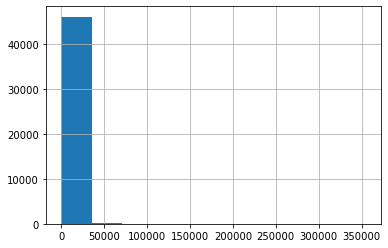

In [11]:
customers.revenue.hist()

This isn't very helpful, did someone really spend $350,000??

Let me clip it to 90th quantile

<AxesSubplot:>

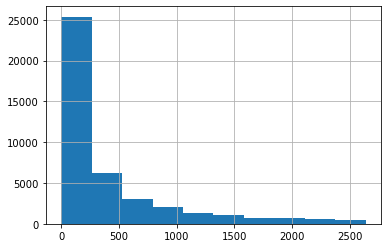

In [12]:
customers.revenue\
.pipe(lambda s: s[lambda x: x<=x.quantile(0.9)])\
.hist()

That makes much more sense in an eCommerce context, I'll go with it

Time to write the SQL

In [13]:
sql_str1 = """
select 
    sum(revenue) Total_Revenue,
    round(sum(revenue)) Total_Revenue_Rounded
from 
    customers
where
    cc_payments = 1
"""

with SqlLitePandasAdapter(db_path) as q:
    df_answer1 = q.query(sql_str1)

In [14]:
df_answer1

,Total_Revenue,Total_Revenue_Rounded
0,50372281.74,50372282.0


There goes the answer: $50,372,282

I also printed the un-rounded number just in case Sqlite's ROUND() function behaves unexpectedly

# Question 2
__What percentage of customers who have purchased female items have paid by credit card?__

First of all what is a "female item"? Let me examine the entire dataframe closely. 

In [15]:
with pd.option_context('display.max_rows', 20, 'display.max_columns', 999):
    display(customers.sample(10))

,customer_id,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,cancels,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,apple_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,wspt_items,mspt_items,curvy_items,sacc_items,msite_orders,desktop_orders,android_orders,ios_orders,other_device_orders,work_orders,home_orders,parcelpoint_orders,other_collection_orders,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used,revenue
7330,0d646c1e5fd241027a002382484755b0,1771,39960,Y,3,4,0,0,0,2,1,0,0,1,0,0,2,2,0,0,2,1,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,3,131.60,0.00,0.6166,6165.8100,77.18
45365,3e3656f155a25f9d52890e050579e55f,406,9720,N,2,5,0,5,0,1,1,1,0,1,0,0,5,0,0,5,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0,0,447.80,287.76,0.3352,5892.8907,509.01
18678,1f3c171be04c357136e1d439b9adef03,1740,34104,Y,4,6,0,0,0,1,1,0,0,1,0,0,4,2,0,0,2,2,2,2,0,0,0,0,0,0,4,0,0,0,0,0,0,4,64.20,0.00,0.1998,1998.3928,229.86
8690,de7552f9d95794ee8975b38b96e1b98e,1765,42360,N,1,3,0,0,0,1,1,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,119.88,0.00,0.2667,2666.6667,247.86
23494,826daaa5f737a3e3bc74d7725d438592,1640,39360,Y,1,14,0,0,0,1,1,0,1,0,0,0,11,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1336.72,0.00,0.2007,2006.7230,4686.92
32789,5db1690aa8755de8459a32ce18a7e3f5,194,4656,N,1,2,0,0,0,1,1,0,1,0,0,0,2,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,32.68,NaN,0.1499,1499.0826,312.58
10616,74816a0acda471b1f2aeb250cc0c1183,1784,42096,N,2,4,0,1,1,2,1,0,1,0,0,0,2,2,0,2,0,1,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,2,187.16,0.00,0.1999,1999.3795,721.52
18672,2446d453586c0a4d45074d11def2208c,1721,41304,N,1,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.00,0.00,0.0000,0.0000,36.35
5844,1bc8f8b6e7043bc98406ea124ad57811,1785,42840,N,1,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,32.70,0.00,0.6000,6000.0000,21.80
21931,aba9754503982dd33ac26258118f4860,1703,40080,Y,3,5,0,2,0,1,1,0,1,0,0,0,3,0,2,2,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,3,479.83,0.00,0.5801,5801.0604,327.82


Ok it's just a column called "female_items", that's straightfoward. Need to examine the value so there's no surprise:

In [16]:
customers.female_items.describe()

count    46279.000000
mean         6.465827
std         17.805349
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max        537.000000
Name: female_items, dtype: float64

Someone bought 537 female products? But 75th percentile of 5 items and no negative numbers etc, we should be good

In [17]:
sql_str2 = """
select
    n_cust_cc, 
    n_cust_no_cc,
    1.0 * n_cust_cc / (n_cust_cc + n_cust_no_cc)*100 pctg_cc
from (
    select
        sum(case when cc_payments<>0 then n_cust else 0 end) n_cust_cc,
        sum(case when cc_payments=0 then n_cust else 0 end) n_cust_no_cc
    from (
        select 
            cc_payments,
            count(*) n_cust
        from 
            customers
        where
            female_items > 0
        group by 
            cc_payments
    )
)
"""

with SqlLitePandasAdapter(db_path) as q:
    df_answer2 = q.query(sql_str2)

df_answer2

,n_cust_cc,n_cust_no_cc,pctg_cc
0,22588,11935,65.428845


So the answer is 65.428845%

Doing pivoting in SQL is annoying, not sure Sqlite3 has similar pivoting function like MS SQL Server but didn't have time to check. Let me double check with pandas. 

In [18]:
(customers
 .assign(bought_female=lambda df: df.female_items>0) # define boolean flag for bought female_items
 .assign(paid_by_cc=lambda df: df.cc_payments>0) # define boolean flag for paid by creditcard
 [lambda df: df.bought_female] # filter on those who bought female item
 .groupby('paid_by_cc') # group by and count
 .size()
 .rename('n_cust')
 .pipe(lambda s: s[True]/s.sum()) # calculate percentage
)

0.6542884453842366

Ok that wasn't much eaiser but it's more intuitive.. maybe? I'm sure there are better ways. 

# Question 3
__What was the average revenue for customers who used either iOS, Android or Desktop?__

These 3 columns seem relevant: desktop_orders,android_orders,ios_orders

This feels way too easy, is this a trick question?

In [19]:
customers[['desktop_orders', 'android_orders', 'ios_orders']].describe()

,desktop_orders,android_orders,ios_orders
count,46279.000000,46279.000000,46279.000000
mean,2.624149,0.042935,0.462953
std,6.094596,0.535762,2.488750
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,3.000000,0.000000,0.000000
max,665.000000,33.000000,84.000000


In [20]:
(customers[['desktop_orders', 'android_orders', 'ios_orders']]>0).sum()

desktop_orders    36523
android_orders      754
ios_orders         4975
dtype: int64

Surprised to see how few customers were ordering from Android or iOS

In [21]:
sql_str3 = """
select 
    avg(revenue) avg_revenue
from 
    customers
where
    desktop_orders > 0 
    or android_orders > 0
    or ios_orders > 0
"""

with SqlLitePandasAdapter(db_path) as q:
    df_answer3 = q.query(sql_str3)

df_answer3

,avg_revenue
0,1484.889118


The answer is $1,484.889118

I still think this is a trick question, but anyway..

# Question 4
__We want to run an email campaign promoting a new mens luxury brand. Can you provide a list of customers we should send to?__

This is quite open ended, an SME would have better view on the select criteria. I'll keep it simple: 

customers who have bought mens products -> relevant segment

recently -> active customers

and have the highest average spend per item -> proxy for luxury purchase

In [22]:
customers.male_items.describe()

count    46279.000000
mean         1.719203
std          5.464658
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        273.000000
Name: male_items, dtype: float64

In [23]:
male_item_customers = customers[lambda df: df.male_items>0]

In [24]:
(male_item_customers
 .days_since_last_order.describe()
)

count    17186.000000
mean     22632.625626
std      16786.939261
min         24.000000
25%       5112.000000
50%      22044.000000
75%      40968.000000
max      50688.000000
Name: days_since_last_order, dtype: float64

This can't be right

In [25]:
(male_item_customers
 .days_since_last_order
 .pipe(lambda s: s/365)
 .rename('years_since_last_order')
 .describe()
)

count    17186.000000
mean        62.007193
std         45.991614
min          0.065753
25%         14.005479
50%         60.394521
75%        112.241096
max        138.871233
Name: years_since_last_order, dtype: float64

Mean average time since last order is 60 years??

Let me take a step back and clean this up first. Because I really want to use this column. 

In [26]:
customers[['days_since_first_order', 'days_since_last_order']].describe()

,days_since_first_order,days_since_last_order
count,46279.000000,46279.000000
mean,1374.041444,24592.675382
std,604.972862,16935.826675
min,1.000000,24.000000
25%,910.000000,6816.000000
50%,1713.000000,25560.000000
75%,1786.000000,41640.000000
max,2164.000000,51840.000000


In [27]:
customers.days_since_first_order.max()/365

5.928767123287671

According to Wikipedia, The ICONIC lauched in 2011, so max first order of 5.9 years is reasonable. 

If days_since_last_order is not actually days, and assume it's fixable, it's most likely measured in the wrong unit. Given the min value is 24, let me try treating it as hours instead of days.

In [28]:
customers.days_since_last_order.pipe(lambda s: s/24/365).rename('years_since_last_order').describe()

count    46279.000000
mean         2.807383
std          1.933314
min          0.002740
25%          0.778082
50%          2.917808
75%          4.753425
max          5.917808
Name: years_since_last_order, dtype: float64

Max is just a little bit smaller than max first order! This must be it!

In [29]:
customers_fixed = customers.assign(days_since_last_order=lambda df: df.days_since_last_order/24)

I think I might have done part of the next challenge by fixing this. Totally fogot about this instruction:
> Note: At this stage it is ok to ignore the underlying errors in the data

Anyway

Now let's try this again

In [30]:
male_item_customers = customers_fixed[lambda df: df.male_items>0]

In [31]:
(male_item_customers
 .days_since_last_order.describe()
)

count    17186.000000
mean       943.026068
std        699.455803
min          1.000000
25%        213.000000
50%        918.500000
75%       1707.000000
max       2112.000000
Name: days_since_last_order, dtype: float64

In [32]:
male_item_customers[lambda df: df.days_since_last_order<df.days_since_last_order.quantile(0.25)].pipe(len)

4296

In [33]:
active_male_item_customers = male_item_customers[lambda df: df.days_since_last_order<df.days_since_last_order.quantile(0.25)]

Top 25 percentile of most active male product purchasers gives us a list of 4296 customers

Now I'll pick the luxury buyers from them

In [34]:
(active_male_item_customers
 .assign(mean_rev_per_item=lambda df: df.revenue/df['items'])
 .mean_rev_per_item
 .describe(percentiles=[.50, .60, .70, .80,.90, .95, .96, .97, .98, .99])
)

count    4296.000000
mean      135.509033
std       102.310184
min         0.000000
50%       112.390455
60%       128.672414
70%       148.170193
80%       178.560909
90%       236.393333
95%       305.301591
96%       327.771225
97%       365.142392
98%       402.484675
99%       483.647633
max      1562.796957
Name: mean_rev_per_item, dtype: float64

That 90th percentile looks pretty good, should give us about 430 customers. It's a tiny list in email campaign standard but since this is just a tech challenge I'll leave it at that instead of re-tweaking the parameters. 

SQL time!

In [35]:
sql_str4 = """
select 
    customer_id
from 
    customers
where
    customer_id in (
        select 
            customer_id
        from
            customers
        where
            male_items > 0
        order by
            days_since_last_order asc
        limit 4296
    )
order by 
    (revenue/items) desc
limit 430
"""

with SqlLitePandasAdapter(db_path) as q:
    df_answer4 = q.query(sql_str4)

df_answer4

,customer_id
0,07470e20e3fedf65d1acf848b384c2ce
1,ac4e68a4a845aa53e72cc4d4b14c7c7a
2,9ac00fdbd1e26180956f9ca04787a7b9
3,31100a449e53e5a6cb5b92d237f47721
4,77e1a79a7ea77d1b616fb6f488c1a962
...,...
425,0d63e7093346933ecd105502bb76bd57
426,80af9d311465ad70ec0f868aa118a853
427,98c12f5a526e1e756696cca1115d0aad
428,b759dc591fb93bc241ac31d787e49d96


Here we go, a list of 430 customers who have been relatively active and purchased males items, and have the top 10 percentiles highest average revenue per item. 